<a href="https://colab.research.google.com/github/samas-sha/Git-project/blob/main/Copy_of_unsupervised_case_study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
data = pd.read_csv("/content/adult_dataset.csv")
data.head()

In [ ]:
data.shape

In [ ]:
data.replace('?', np.nan, inplace=True)
for col in data.select_dtypes(include='object').columns:
    data[col].fillna(data[col].mode()[0], inplace=True)

for col in data.select_dtypes(include=['int64','float64']).columns:
    data[col].fillna(data[col].median(), inplace=True)


In [ ]:
data.isnull().sum()

In [ ]:
num_cols = data.select_dtypes(include=['int64','float64']).columns

for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(data[col], kde=True, bins=30)
    plt.title(f"Distribution of {col}")
    plt.show()

In [ ]:
num_cols = data.select_dtypes(include=['int64','float64']).columns
outlier_summary = {}

for col in num_cols:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)][col]
    outlier_summary[col] = len(outliers)

    plt.figure(figsize=(6,4))
    sns.boxplot(x=data[col])
    plt.title(f"Outlier Detection: {col}")
    plt.show()

    print(f"{col}: {len(outliers)} outliers detected")

outlier_summary

In [ ]:
num_cols = data.select_dtypes(include=['int64','float64']).columns

for col in num_cols:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    data = data[(data[col] >= lower_bound) & (data[col] <= upper_bound)]

In [ ]:
data


In [ ]:
num_cols = ['age','fnlwgt','education-num','capital-gain','capital-loss','hours-per-week']

for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(data[col], kde=True, bins=30)
    plt.title(f"Distribution of {col}")
    plt.show()

    plt.figure(figsize=(6,4))
    sns.boxplot(x=data[col])
    plt.title(f"Boxplot of {col}")
    plt.show()

In [ ]:
num_cols = ['age','fnlwgt','education-num','capital-gain','capital-loss','hours-per-week']
corr_matrix = data[num_cols].corr(method='pearson')

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Initial Dataset (Numerical Features)", fontsize=14)
plt.show()

In [ ]:
y = data['income']
data = data.drop(columns=['income','fnlwgt','education'])



In [ ]:
cat_cols = ['workclass','occupation','marital-status','relationship',
            'race','sex','native-country']
data_encoded = pd.get_dummies(data, columns=cat_cols, drop_first=True).astype(int)


In [ ]:

plt.figure(figsize=(12,8))
sns.heatmap(data_encoded.corr(), cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap")
plt.show()

In [ ]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_encoded)
data_scaled


In [ ]:
pca = PCA().fit(data_scaled)
explained_variance = pca.explained_variance_ratio_

import numpy as np
cum_var = np.cumsum(explained_variance)
print(cum_var)

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(np.cumsum(explained_variance))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot for PCA')
plt.grid(True)
plt.show()

In [ ]:

pca = PCA(n_components=2)
pca_result = pca.fit_transform(data_scaled)

plt.figure(figsize=(8,6))
plt.scatter(pca_result[:,0], pca_result[:,1], alpha=0.5)
plt.title("PCA Projection (2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [ ]:
pca = PCA(n_components=0.90)
data_pca = pca.fit_transform(data_scaled)

In [ ]:
pca_df = pd.DataFrame(
    data_pca,
    columns=[f'PC{i+1}' for i in range(data_pca.shape[1])]
)
print(pca_df.head())


#Clustering

In [ ]:
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_pca)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.show()

- High Dimensionality (80+ features after encoding)
- With many features, the WCSS (inertia) curve can drop smoothly without a sharp bend.
- The “elbow” becomes less obvious because variance is spread across many dimensions.
- Option 2: Use Silhouette Score Alongside Elbow


In [ ]:
scores = {}
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(data_pca)
    score = silhouette_score(data_pca, labels)
    scores[k] = score
    print(f"k={k}, silhouette score={score:.3f}")

best_k = max(scores, key=scores.get)
print("Best number of clusters based on silhouette:", best_k)

In [ ]:
best_k = 2

kmeans = KMeans(n_clusters=best_k, init='k-means++', max_iter=300, n_init=10, random_state=0)
labels = kmeans.fit_predict(data_pca)

data['cluster'] = labels

In [ ]:
data['cluster']

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(data_pca[:,0], data_pca[:,1], c=labels, cmap='viridis', alpha=0.6)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"KMeans Clusters (k={best_k}) visualized with PCA")
plt.show()

In [ ]:
ct = pd.crosstab(data['cluster'], y)
ct

In [ ]:
plt.figure(figsize=(6, 4))
sns.heatmap(ct, annot=True, fmt="d", cmap="Blues")
plt.ylabel("KMeans clusters")
plt.xlabel("Income")
plt.title("Income vs KMeans clusters")
plt.tight_layout()
plt.show()


#AgglomerativeClustering

In [ ]:
X = np.array(data_scaled)

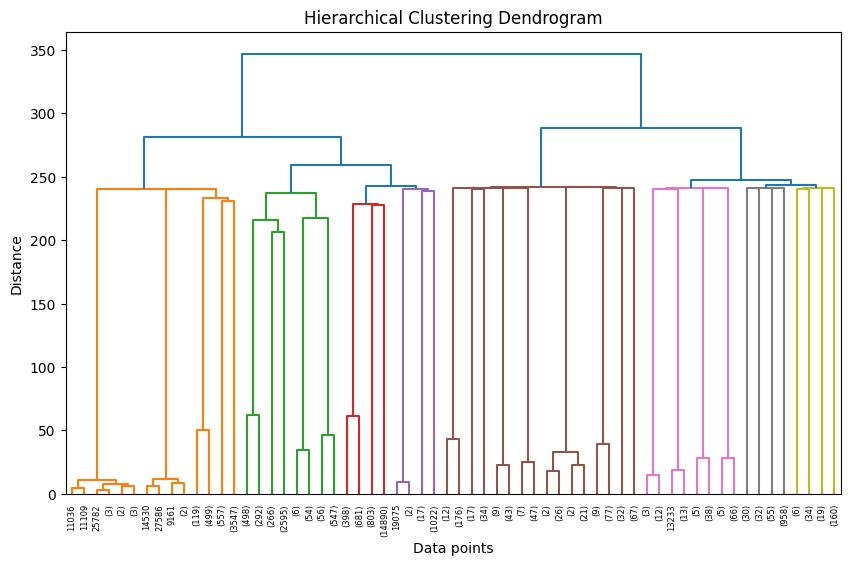

In [ ]:
Z = linkage(data_scaled, method='ward')
plt.figure(figsize=(10,6))
dendrogram(Z, truncate_mode='level', p=5)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Data points")
plt.ylabel("Distance")
plt.show()

In [ ]:
scores = {}
for k in range(2, 11):
    agg = AgglomerativeClustering(n_clusters=k, linkage='ward')
    labels = agg.fit_predict(data_pca)
    score = silhouette_score(data_pca, labels)
    scores[k] = score
    print(f"k={k}, silhouette score={score:.3f}")

best_k = max(scores, key=scores.get)
print("Best number of clusters based on silhouette:", best_k)

k=2, silhouette score=0.624
k=3, silhouette score=0.625
k=4, silhouette score=0.125
k=5, silhouette score=0.115


In [ ]:
best_k = 3
agg = AgglomerativeClustering(n_clusters=best_k, linkage='ward')
labels = agg.fit_predict(data_pca)

data['agg_cluster'] = labels

In [ ]:
data['agg_cluster']

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(data_pca[:,0], data_pca[:,1], c=labels, cmap='viridis', alpha=0.6)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f" AgglomerativeClustering (k={best_k}) visualized with PCA")
plt.show()

In [ ]:
ct2 = pd.crosstab(data['agg_cluster'], y)
ct2

In [ ]:
plt.figure(figsize=(6, 4))
sns.heatmap(ct2, annot=True, fmt="d", cmap="Blues")
plt.ylabel("AgglomerativeClusters")
plt.xlabel("Income")
plt.title("Income vs AgglomerativeClusters")
plt.tight_layout()
plt.show()


In [ ]:
cluster_profile = data.groupby('agg_cluster').mean(numeric_only=True)
print(cluster_profile)

In [ ]:
categorical_profile = pd.crosstab(data['agg_cluster'], y, normalize='index')
print(categorical_profile)